Removed letterbox: Top=235px, Bottom=235px
Saved image with embedded metrics to /Users/greyson/Projects/custom_gallery/gallery/public/img/cameronmarygold/2021-07-06_16-54-00_CQ_j8VorM1y/209772164_1970922413072622_4634697276599521314_n.jpg


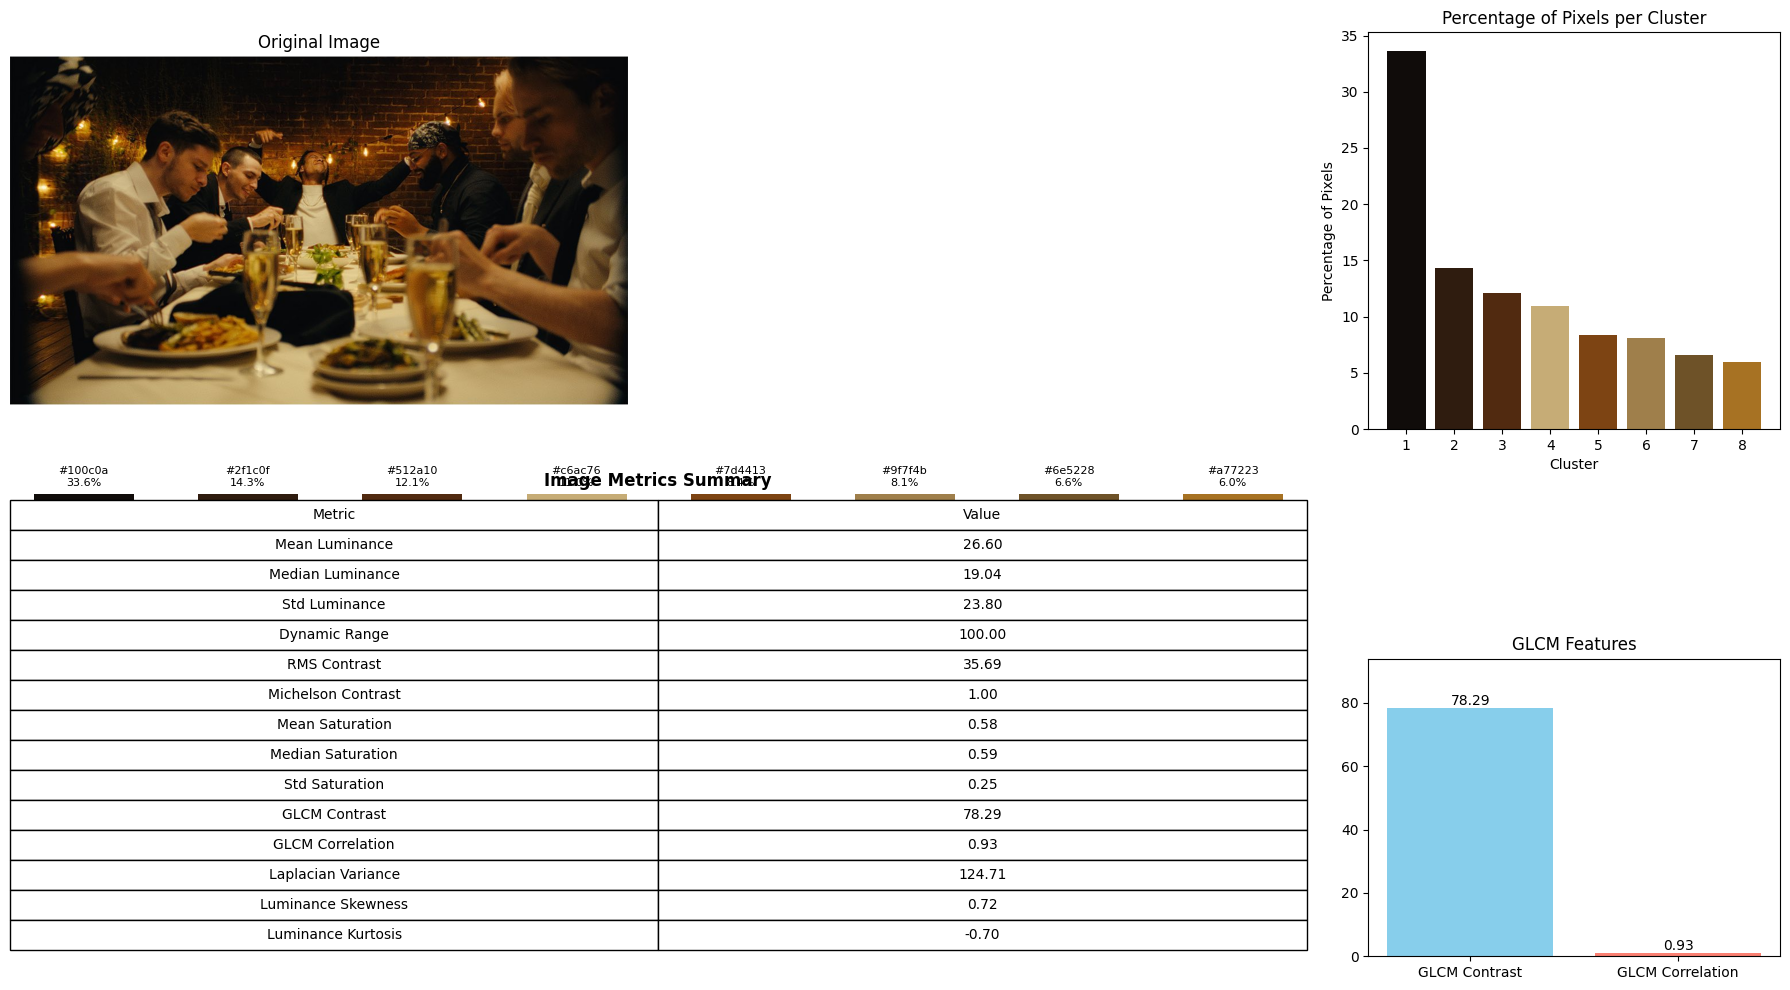

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color, feature
from collections import Counter
from scipy.stats import skew, kurtosis
import matplotlib.gridspec as gridspec
import cv2
import piexif
import json
import sys

def is_similar(row, tolerance=10):
    """
    Check if all pixels in the row are similar within the given tolerance.
    """
    # Compute the difference between max and min for each channel
    diff = row.max(axis=0) - row.min(axis=0)
    return np.all(diff < tolerance)

def find_letterbox_height(image_np, tolerance=10, min_height=10, from_top=True):
    """
    Find the height of the letterbox from the top or bottom.
    """
    height, width, _ = image_np.shape
    letterbox_height = 0
    range_y = range(height) if from_top else range(height-1, -1, -1)
    
    for y in range_y:
        row = image_np[y, :, :]
        if is_similar(row, tolerance):
            letterbox_height +=1
        else:
            break
    # Ensure the detected letterbox is at least min_height pixels
    if letterbox_height >= min_height:
        return letterbox_height
    else:
        return 0

def remove_letterbox(image_np, tolerance=10, min_letterbox_height=10):
    """
    Detect and remove letterboxing from the top and bottom of the image.
    """
    top_height = find_letterbox_height(image_np, tolerance, min_letterbox_height, from_top=True)
    bottom_height = find_letterbox_height(image_np, tolerance, min_letterbox_height, from_top=False)
    
    if top_height > 0 or bottom_height > 0:
        cropped_image = image_np[top_height: image_np.shape[0] - bottom_height, :, :]
        print(f"Removed letterbox: Top={top_height}px, Bottom={bottom_height}px")
        return cropped_image
    else:
        print("No letterbox detected.")
        return image_np

def embed_metrics_into_exif(image_path, output_path, metrics_dict):
    """
    Embed the metrics dictionary into the JPEG's EXIF UserComment field.
    """
    try:
        # Load existing EXIF data
        exif_dict = piexif.load(image_path)
    except Exception as e:
        print(f"Error loading EXIF data: {e}")
        exif_dict = {"0th": {}, "Exif": {}, "GPS": {}, "1st": {}, "thumbnail": None}
    
    # Convert metrics dictionary to JSON string
    metrics_json = json.dumps(metrics_dict)
    
    # EXIF UserComment requires a specific format: a character code followed by the comment
    # We'll use ASCII encoding for simplicity
    user_comment = "ASCII\0\0\0" + metrics_json
    
    # Encode the comment to bytes
    user_comment_bytes = user_comment.encode('utf-8')
    
    # Insert the UserComment into EXIF
    exif_dict['Exif'][piexif.ExifIFD.UserComment] = user_comment_bytes
    
    # Dump the EXIF data to bytes
    exif_bytes = piexif.dump(exif_dict)
    
    # Save the image with new EXIF data
    try:
        image = Image.open(image_path)
        image.save(output_path, "jpeg", exif=exif_bytes)
        print(f"Saved image with embedded metrics to {output_path}")
    except Exception as e:
        print(f"Error saving image with EXIF data: {e}")

# Step 1: Load the image
imagePath = "/Users/greyson/Projects/custom_gallery/gallery/public/img/cameronmarygold/2021-07-06_16-54-00_CQ_j8VorM1y/209772164_1970922413072622_4634697276599521314_n.jpg"
outputImagePath = imagePath

try:
    image = Image.open(imagePath)
except FileNotFoundError:
    print(f"Image not found at path: {imagePath}")
    sys.exit(1)

image_np = np.array(image)

# Ensure the image is in RGB format
if image.mode != 'RGB':
    image = image.convert('RGB')
    image_np = np.array(image)

# Remove alpha channel if present
if image_np.shape[2] == 4:
    image_np = image_np[:, :, :3]

# *** Added Section: Detect and Remove Letterbox ***
# Parameters can be adjusted based on the expected letterbox characteristics
tolerance = 15           # Tolerance for color similarity (0-255)
min_letterbox_height = 10  # Minimum height in pixels to consider as letterbox

image_np = remove_letterbox(image_np, tolerance, min_letterbox_height)

# Step 2: Normalize and convert to LAB color space
image_normalized = image_np / 255.0
image_lab = color.rgb2lab(image_normalized)

# Step 3: Reshape image data for clustering
pixels_lab = image_lab.reshape(-1, 3)

# Step 4: Perform k-means clustering with k=8
k = 8  # Set the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)

# Step 5: Process cluster centers
cluster_centers_lab = kmeans.cluster_centers_
cluster_centers_rgb = color.lab2rgb(cluster_centers_lab.reshape(1, -1, 3))
cluster_centers_rgb = np.squeeze(cluster_centers_rgb)
cluster_centers_rgb_uint8 = np.clip(cluster_centers_rgb * 255, 0, 255).astype(int)

# Step 6: Quantify and visualize cluster sizes
labels = kmeans.labels_
counts = Counter(labels)
total_pixels = sum(counts.values())

# Sort clusters by the number of pixels
sorted_counts = counts.most_common()
sorted_cluster_indices = [item[0] for item in sorted_counts]
sorted_cluster_sizes = [item[1] for item in sorted_counts]
sorted_cluster_percentages = [(count / total_pixels) * 100 for count in sorted_cluster_sizes]
sorted_colors_rgb = np.array([cluster_centers_rgb_uint8[i] for i in sorted_cluster_indices])

# Prepare colors for bar charts (normalized to [0, 1])
bar_colors = sorted_colors_rgb / 255
cluster_numbers = range(1, k + 1)

# *** Added Section: Compute Additional Image Metrics ***

# Convert LAB to HSV for saturation metrics
image_hsv = color.rgb2hsv(image_normalized)
saturation = image_hsv[:, :, 1]
mean_saturation = np.mean(saturation)
median_saturation = np.median(saturation)
std_saturation = np.std(saturation)

# Luminance Metrics
l_channel = image_lab[:, :, 0]
mean_luminance = np.mean(l_channel)
median_luminance = np.median(l_channel)
std_luminance = np.std(l_channel)
dynamic_range = l_channel.max() - l_channel.min()

# Contrast Metrics
rms_contrast = np.sqrt(np.mean(l_channel**2))
michelson_contrast = (l_channel.max() - l_channel.min()) / (l_channel.max() + l_channel.min())

# Texture Features using GLCM
glcm = feature.graycomatrix(l_channel.astype(np.uint8), distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
glcm_contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
glcm_correlation = feature.graycoprops(glcm, 'correlation')[0, 0]

# Sharpness using Variance of Laplacian
laplacian_var = cv2.Laplacian(l_channel, cv2.CV_64F).var()

# Skewness and Kurtosis of Luminance
lum_skew = skew(l_channel.flatten())
lum_kurt = kurtosis(l_channel.flatten())

# Compile Features
additional_features = {
    'Mean Luminance': f"{mean_luminance:.2f}",
    'Median Luminance': f"{median_luminance:.2f}",
    'Std Luminance': f"{std_luminance:.2f}",
    'Dynamic Range': f"{dynamic_range:.2f}",
    'RMS Contrast': f"{rms_contrast:.2f}",
    'Michelson Contrast': f"{michelson_contrast:.2f}",
    'Mean Saturation': f"{mean_saturation:.2f}",
    'Median Saturation': f"{median_saturation:.2f}",
    'Std Saturation': f"{std_saturation:.2f}",
    'GLCM Contrast': f"{glcm_contrast:.2f}",
    'GLCM Correlation': f"{glcm_correlation:.2f}",
    'Laplacian Variance': f"{laplacian_var:.2f}",
    'Luminance Skewness': f"{lum_skew:.2f}",
    'Luminance Kurtosis': f"{lum_kurt:.2f}"
}

# *** End of Added Section ***

# *** New Section: Embed Metrics into EXIF Metadata ***
# Ensure piexif is installed. If not, provide instructions.
try:
    import piexif
except ImportError:
    print("The 'piexif' library is required to embed metadata. Install it using 'pip install piexif'.")
    sys.exit(1)

# Embed the metrics into EXIF metadata
embed_metrics_into_exif(imagePath, outputImagePath, additional_features)

# Create a figure with GridSpec
# fig = plt.figure(figsize=(18, 10))
# gs = gridspec.GridSpec(nrows=3, ncols=3, width_ratios=[3, 3, 2], height_ratios=[4, 1, 3])

# # Display the original image in the top-left
# ax_image = fig.add_subplot(gs[0, 0])
# ax_image.imshow(image_np)
# ax_image.axis('off')
# ax_image.set_title('Original Image')

# # Plot color swatches underneath the image in the top-center
# gs_swatches = gridspec.GridSpecFromSubplotSpec(1, k, subplot_spec=gs[1, 0:2])
# for i in range(k):
#     ax = fig.add_subplot(gs_swatches[0, i])
#     swatch = np.zeros((50, 50, 3), dtype=int)
#     swatch[:, :] = sorted_colors_rgb[i]
#     ax.imshow(swatch)
#     ax.axis('off')
#     hex_color = '#{:02x}{:02x}{:02x}'.format(*sorted_colors_rgb[i])
#     percentage = sorted_cluster_percentages[i]
#     ax.set_title(f"{hex_color}\n{percentage:.1f}%", fontsize=8)

# # Plot the bar chart in the top-right
# ax_bar = fig.add_subplot(gs[0, 2])
# ax_bar.bar(cluster_numbers, sorted_cluster_percentages, color=bar_colors)
# ax_bar.set_xlabel('Cluster')
# ax_bar.set_ylabel('Percentage of Pixels')
# ax_bar.set_title('Percentage of Pixels per Cluster')
# ax_bar.set_xticks(cluster_numbers)

# # Plot additional features as a table in the bottom-left
# ax_table = fig.add_subplot(gs[1:, 0:2])
# ax_table.axis('off')
# table_data = list(additional_features.items())
# table = ax_table.table(cellText=table_data, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1, 1.5)
# ax_table.set_title('Image Metrics Summary', fontweight='bold')

# # Optionally, visualize texture features (e.g., GLCM)
# # Here, we'll display a simple bar chart for GLCM features
# ax_glcm = fig.add_subplot(gs[2, 2])
# glcm_metrics = ['GLCM Contrast', 'GLCM Correlation']
# glcm_values = [glcm_contrast, glcm_correlation]
# ax_glcm.bar(glcm_metrics, glcm_values, color=['skyblue', 'salmon'])
# ax_glcm.set_ylim(0, max(glcm_values)*1.2)
# ax_glcm.set_title('GLCM Features')
# for i, v in enumerate(glcm_values):
#     ax_glcm.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# plt.tight_layout()
# plt.show()
